In [1]:
library(brms) #predictability: Double hierearchical model
library(MCMCglmm) #HPDinterval

Warning message:
"le package 'brms' a été compilé avec la version R 4.1.2"
Le chargement a nécessité le package : Rcpp

Warning message:
"le package 'Rcpp' a été compilé avec la version R 4.1.2"
Loading 'brms' package (version 2.16.3). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attachement du package : 'brms'


L'objet suivant est masqué depuis 'package:stats':

    ar


Warning message:
"le package 'MCMCglmm' a été compilé avec la version R 4.1.2"
Le chargement a nécessité le package : Matrix

Warning message:
"le package 'Matrix' a été compilé avec la version R 4.1.2"
Le chargement a nécessité le package : coda

Warning message:
"le package 'coda' a été compilé avec la version R 4.1.2"
Le chargement a nécessité le package : ape

Warning message:
"le package 'ape' a été compilé avec la version R 4.1.2"

Attachement du package : 'MCMCglmm'


L'objet suivant est masqué depuis 'pac

In [2]:
#install.packages("dplyr")

In [3]:
#citation("merTools")

In [4]:
library(parallel)
my.cores = detectCores()

# Download data

In [5]:
path_ = 'G:/VPHI/Welfare/2- Research Projects/OFHE2.OriginsE2/DataOutput/TrackingSystem/ALLDATA_'
path_adapt = file.path(path_,'Adaptability')
path_model = file.path(path_adapt,'repeatability_model')
df = read.csv(file.path(path_adapt,'df_MVT_4individuality_withPCA.csv'), header = TRUE, sep = ",")
df$HenID = as.factor(df$HenID)   
df$PenID = as.factor(df$PenID) 
df$cDIB = as.integer(df$DIB) 
df$cDIB2 = poly(df$cDIB, degree=2,raw=TRUE)[,2]
df$CLASS = as.factor(df$CLASS) 
df$Treatment = as.factor(df$Treatment)
#scale: mean-centering of the environmental variable so that intercepts reflect average values for the population and ind. 
df$temperature_C_avg_scale = scale(df$temperature_C_avg, center=TRUE, scale=TRUE)
df$time = scale(df$cDIB, center=FALSE, scale=TRUE)
df$time2 = poly(df$time, degree=2,raw=TRUE)[,2]
df$avgDIB_scale = scale(df$avgDIB, center=TRUE, scale=TRUE)
df$InitialWeight_scale = scale(df$InitialWeight, center=TRUE, scale=TRUE)
print(dim(df))
summary(df)

[1] 3230   33


     HenID           DIB             CLASS          PenID     temperature_C_avg
 hen_116:  43   Min.   :11.00   EPI     : 478   pen10  :504   Min.   : 4.000   
 hen_124:  43   1st Qu.:23.00   LEXP    : 965   pen11  :504   1st Qu.: 8.667   
 hen_127:  43   Median :33.00   LEXPLOST: 366   pen8   :430   Median :11.000   
 hen_136:  43   Mean   :33.59   MEXP    :1379   pen9   :429   Mean   :10.838   
 hen_147:  43   3rd Qu.:44.00   MEXPLOST:  42   pen4   :388   3rd Qu.:12.667   
 hen_151:  43   Max.   :54.00                   pen5   :363   Max.   :19.333   
 (Other):2972                                   (Other):612                    
  tobeusedPCA     InitialWeight  Treatment_encoded    perc_duration_5_Zone
 Min.   :0.0000   Min.   :1046   Min.   :-1.0000000   Min.   :  0.00      
 1st Qu.:0.0000   1st Qu.:1130   1st Qu.:-1.0000000   1st Qu.: 11.00      
 Median :0.0000   Median :1164   Median :-1.0000000   Median : 33.00      
 Mean   :0.1734   Mean   :1169   Mean   :-0.0006192   Mean  

In [6]:
length(unique(df[['HenID']]))

[1] 80

# Predictibility

In [7]:
#Get information on all parameters (and parameter classes) for which priors may be specified including default priors:
get_prior(formula= PC1~ time + time2 + avgDIB_scale + Treatment_encoded + temperature_C_avg_scale + InitialWeight_scale +(1+ time + time2|HenID), 
          data=df, family = gaussian())

prior,class,coef,group,resp,dpar,nlpar,bound,source
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
,b,,,,,,,default
,b,avgDIB_scale,,,,,,default
,b,InitialWeight_scale,,,,,,default
,b,temperature_C_avg_scale,,,,,,default
,b,time,,,,,,default
,b,time2,,,,,,default
,b,Treatment_encoded,,,,,,default
lkj(1),cor,,,,,,,default
,cor,,HenID,,,,,default


Compiling Stan program...

Start sampling



 Family: gaussian 
  Links: mu = identity; sigma = log 
Formula: PC1 ~ time + time2 + avgDIB_scale + Treatment_encoded + temperature_C_avg_scale + InitialWeight_scale + (1 + time + time2 | HenID) 
         sigma ~ (1 | HenID)
   Data: df (Number of observations: 3230) 
  Draws: 10 chains, each with iter = 5000; warmup = 2500; thin = 3;
         total post-warmup draws = 8334

Group-Level Effects: 
~HenID (Number of levels: 80) 
                     Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)            1.84      0.16     1.55     2.18 1.00    17416
sd(time)                 3.42      0.31     2.86     4.09 1.00    14023
sd(time2)                1.71      0.16     1.42     2.06 1.00    13089
sd(sigma_Intercept)      0.25      0.03     0.21     0.30 1.00    18765
cor(Intercept,time)     -0.85      0.03    -0.91    -0.78 1.00    15558
cor(Intercept,time2)     0.66      0.07     0.51     0.78 1.00    13996
cor(time,time2)         -0.94      0.02    -0.96    -0.90 1.00  

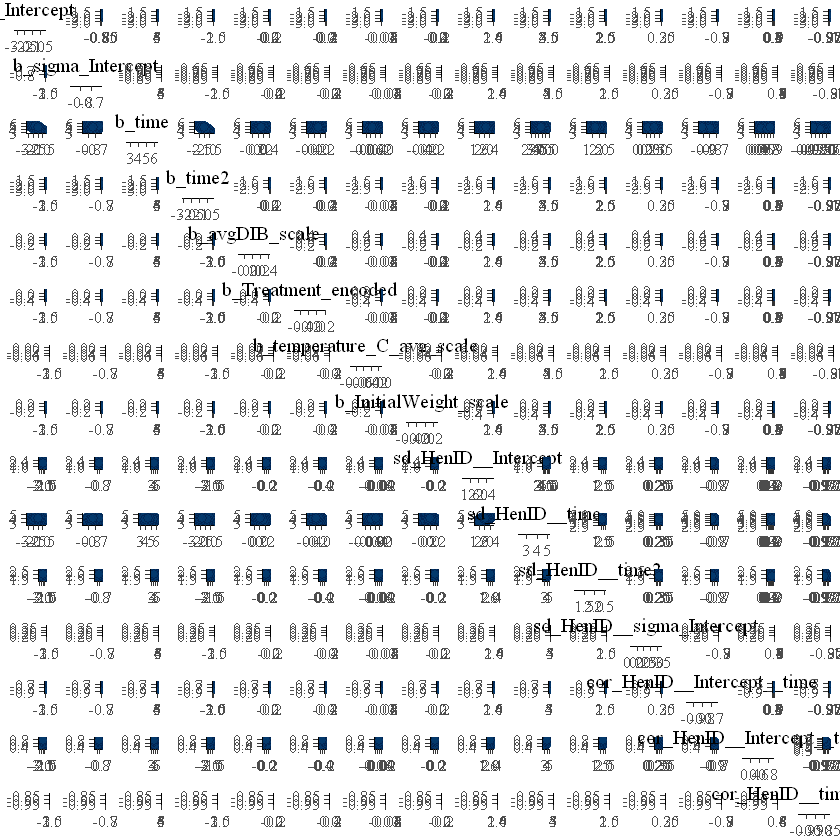

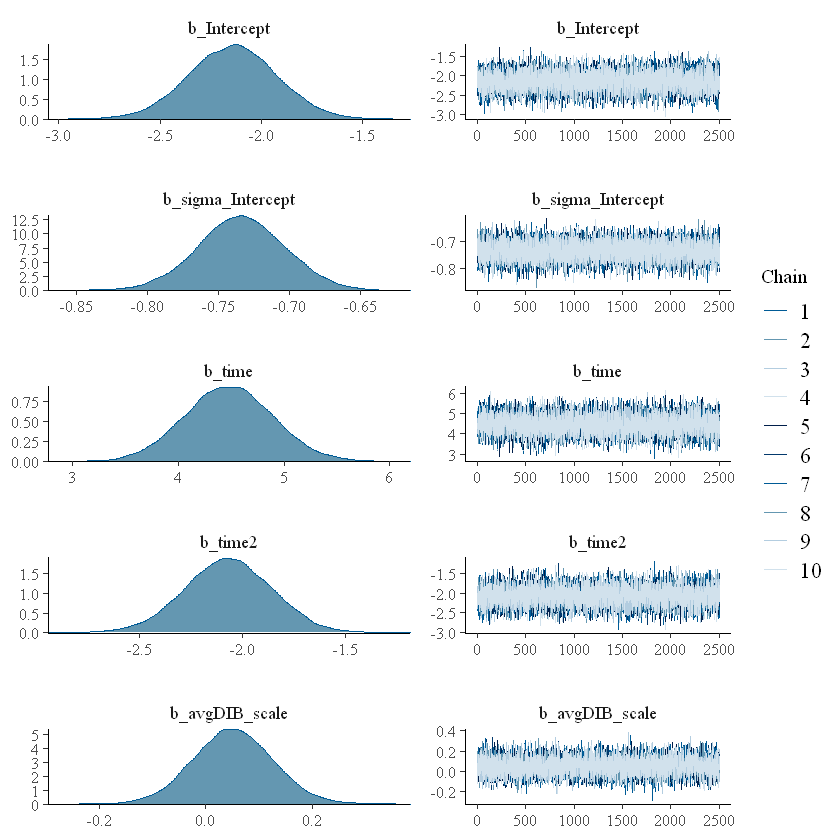

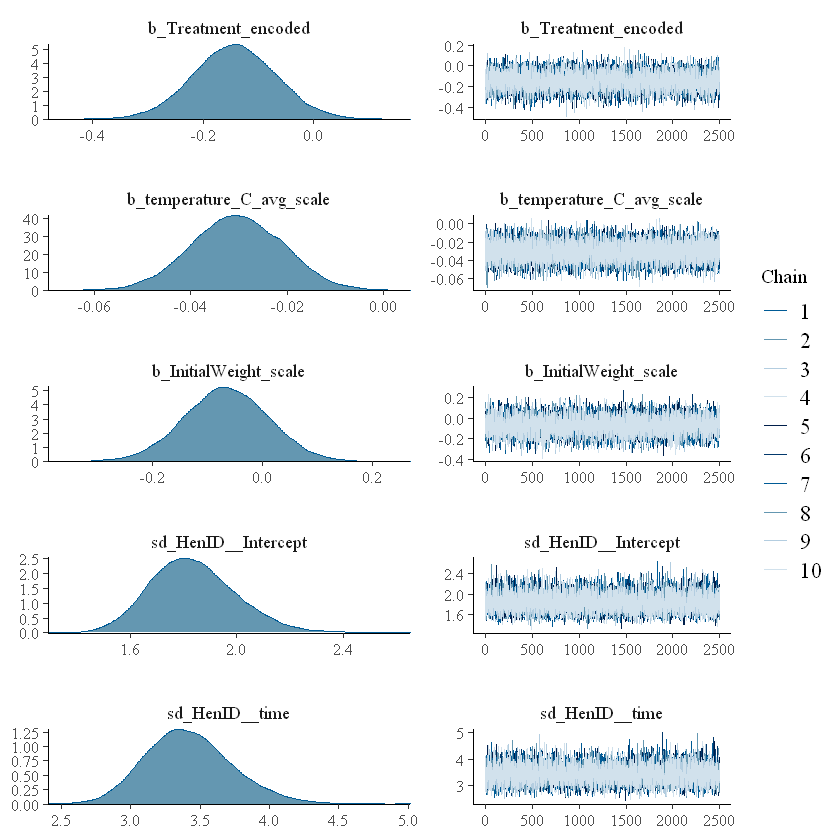

Warning message:
"Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives."


[1] 0.2542731

,lower,upper
var1,0.2059346,0.3080813


prior,class,coef,group,resp,dpar,nlpar,bound,source
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
,b,,,,,,,default
,b,avgDIB_scale,,,,,,default
,b,InitialWeight_scale,,,,,,default
,b,temperature_C_avg_scale,,,,,,default
,b,time,,,,,,default
,b,time2,,,,,,default
,b,Treatment_encoded,,,,,,default
"student_t(3, 0.2, 2.5)",Intercept,,,,,,,default
"student_t(3, 0, 2.5)",Intercept,,,,sigma,,,default


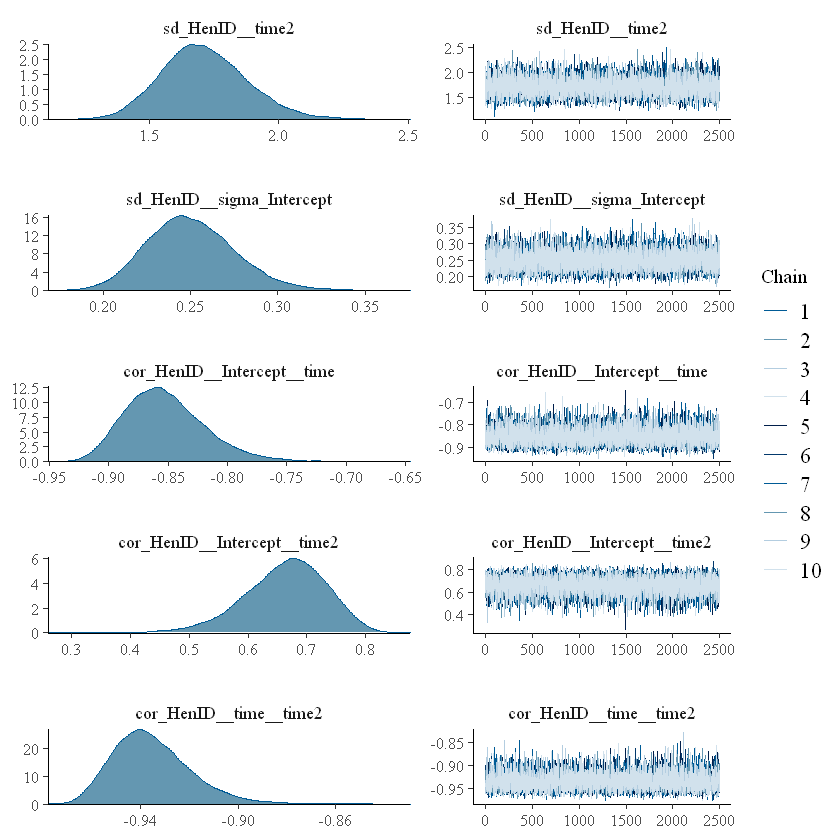

In [8]:
#help(brms) #to cite STAN for the following info:
### bulk-ESS: We recommend requiring that the bulk-ESS is greater than 100 times the number of chains. For example, when running 
#4 chains, this corresponds to having a rank-normalized effective sample size of at least 400.
### R-hat: We recommend running at least four chains by default and only using the sample if R-hat is less than 1.01.
#more info: #https://mc-stan.org/misc/warnings.html#bulk-ess%22
double_model = bf(PC1~ time + time2 + avgDIB_scale + Treatment_encoded + temperature_C_avg_scale + InitialWeight_scale +(1+time+time2|HenID), 
                  sigma~(1|HenID))
modelPred = brm(double_model, data=df, iter=15000, inits="random", seed=12345, control = list(max_treedepth = 15), 
                cores=my.cores, chains=10, thin=3)
             #prior = c(set_prior("student_t(1, 0.01, 0.001)", coef = "temperature_C_avg_scale"),
             #         set_prior("student_t(1, 0.01, 0.001)", coef = "cDIB_scale")))
#modelPred = add_criterion(modelPred, "waic")
summary(modelPred)
pairs(modelPred)
plot(modelPred)
#head(get_variables(modelPred),10)

#coefficient of variation in predictability” (CVP)
log.norm.res = exp(posterior_samples(modelPred)$"sd_HenID__sigma_Intercept"^2)
CVP = sqrt(log.norm.res-1)
mean(CVP);HPDinterval(as.mcmc(CVP),0.95)
#df_pred = posterior_samples(modelPred) #depreciated but still work well. we will instead use:
#extract samples (draw) from the posterior distribution, including all variables
df_pred = as_draws(modelPred)
write.csv(df_pred, file.path(path_adapt,'BLUPS_variability.csv'), row.names = FALSE)
prior_summary(modelPred)

In [9]:
#coefficient of variation in predictability” (CVP)
log.norm.res = exp(posterior_samples(modelPred)$"sd_HenID__sigma_Intercept"^2)
CVP = sqrt(log.norm.res-1)
mean(CVP);HPDinterval(as.mcmc(CVP),0.95)
#df_pred = posterior_samples(modelPred) #depreciated but still work well. we will instead use:
#extract samples (draw) from the posterior distribution, including all variables
df_pred = as_draws(modelPred)
write.csv(df_pred, file.path(path_adapt,'BLUPS_variability.csv'), row.names = FALSE)
prior_summary(modelPred)

Warning message:
"Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives."


[1] 0.2542731

,lower,upper
var1,0.2059346,0.3080813


prior,class,coef,group,resp,dpar,nlpar,bound,source
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
,b,,,,,,,default
,b,avgDIB_scale,,,,,,default
,b,InitialWeight_scale,,,,,,default
,b,temperature_C_avg_scale,,,,,,default
,b,time,,,,,,default
,b,time2,,,,,,default
,b,Treatment_encoded,,,,,,default
"student_t(3, 0.2, 2.5)",Intercept,,,,,,,default
"student_t(3, 0, 2.5)",Intercept,,,,sigma,,,default


In [10]:
#mean population-level residual variance
fixef(modelPred, pars = "sigma_Intercept")[1]

[1] -0.7339463

In [11]:
#add score and save model
add_criterion(modelPred, criterion='bayes_R2', file=file.path(path_adapt,'BRMS_Model_variance'))
#model can be retrieve like this: 
#modelPred = readRDS(file.path(path_adapt,'BRMS_Model_variance_avgDIB_scale.rds'))
#summary(modelPred)

 Family: gaussian 
  Links: mu = identity; sigma = log 
Formula: PC1 ~ time + time2 + avgDIB_scale + Treatment_encoded + temperature_C_avg_scale + InitialWeight_scale + (1 + time + time2 | HenID) 
         sigma ~ (1 | HenID)
   Data: df (Number of observations: 3230) 
  Draws: 10 chains, each with iter = 5000; warmup = 2500; thin = 3;
         total post-warmup draws = 8334

Group-Level Effects: 
~HenID (Number of levels: 80) 
                     Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)            1.84      0.16     1.55     2.18 1.00    17416
sd(time)                 3.42      0.31     2.86     4.09 1.00    14023
sd(time2)                1.71      0.16     1.42     2.06 1.00    13089
sd(sigma_Intercept)      0.25      0.03     0.21     0.30 1.00    18765
cor(Intercept,time)     -0.85      0.03    -0.91    -0.78 1.00    15558
cor(Intercept,time2)     0.66      0.07     0.51     0.78 1.00    13996
cor(time,time2)         -0.94      0.02    -0.96    -0.90 1.00  

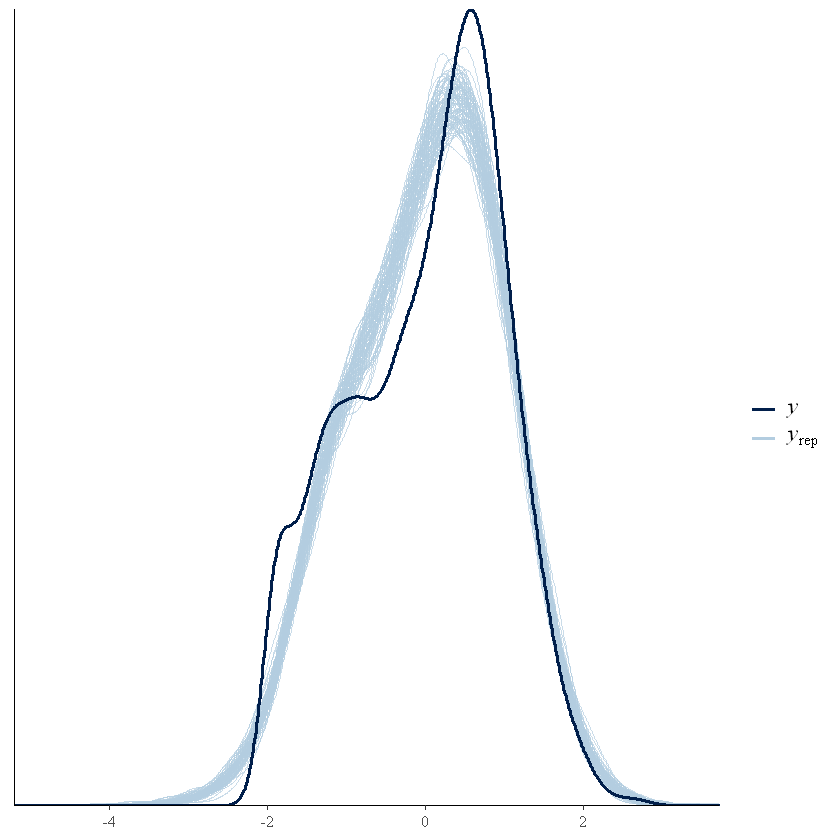

In [12]:
#posterior predictive check
pp_check(modelPred, ndraws = 100)
#-->we don't see any major systematic discrepancies of our data from what can be predicted with modelPred

In [14]:
##https://bookdown.org/marklhc/notes_bookdown/model-diagnostics.html
#additonally marginal model plots could be done with : https://github.com/marklhc/usc-psyc621-notes/blob/master/mmp_brm.R
#as explained here: https://bookdown.org/marklhc/notes_bookdown/model-diagnostics.html#diagnostic-tools